In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

In [8]:
def segment_(data,window_size = 40):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for line in data:
        line = np.array(line).reshape(1,window_size,3)
        segments = np.vstack([segments,line])
    return segments

# init nn parameters
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

# conv
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

# load data

In [32]:
fault_label = {'1': 'info',
               '2': 'Critical',
               '3': 'error',
               '4': 'notice',
               '5': 'warning',
               '6': 'alert',
               '7': 'emergency'}

X, X_val, labels, labels_val = [], [], [], [] #validation set features

with open("data/msg_token_train.txt", 'rU') as f:
        res = list(f)
        for line in res:
            line.strip("\n")
            features = line.split("\t")
            while features.__contains__(""):
                features.remove("")
            for i in range(len(features)):
                features[i] = float(features[i])
            X.append(features)
            
with open("data/msg_label_train.txt", 'rU') as f:
        res = list(f)
        for line in res:
            labels.append(int(line.strip("\n")[0]))
            
with open("data/msg_token_test.txt", 'rU') as f:
        res = list(f)
        for line in res:
            line.strip("\n")
            features = line.split("\t")
            while features.__contains__(""):
                features.remove("")
            for i in range(len(features)):
                features[i] = float(features[i])
            X_val.append(features)
            
with open("data/msg_label_test.txt", 'rU') as f:
        res = list(f)
        for line in res:
            labels_val.append(int(line.strip("\n")[0]))

segments = segment_(X)
segments_val = segment_(X_val)
print(segments.shape)

labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
labels_val = np.asarray(pd.get_dummies(labels_val), dtype = np.int8)
print(labels.shape)

train_x = segments.reshape(len(segments), 1, 40, 3)
train_y = labels
test_x = segments_val.reshape(len(segments_val), 1, 40, 3)
test_y = labels_val

(8360, 40, 3)
(8360, 7)


# define parameters

In [34]:
input_height = 1
input_width = 40
num_channels = 3
num_labels = 7

batch_size = 10
kernel_size = 20
depth = 20
num_hidden = 1000

learning_rate = 0.0001
# iteration times
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

# build network

In [35]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,10,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

# loss func
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1], dtype=float)

# train and test

In [36]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print "Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", \
          session.run(accuracy, feed_dict={X: train_x, Y: train_y})
    y_pred = tf.argmax(y_, 1)
    y_true = np.argmax(test_y, 1)
    final_acc, y_pred = session.run([accuracy, y_pred], feed_dict={X: test_x, Y: test_y})
    print "Testing Accuracy: {}".format(final_acc)
    print()
    
    # model metrics
    temp_y_true = np.unique(y_true)
    temp_y_pred = np.unique(y_pred) 
    np.save("data/y_true", y_true) 
    np.save("data/y_pred", y_pred) 
    print "temp_y_true", temp_y_true 
    print "temp_y_pred", temp_y_pred
    
    print(classification_report(y_true, y_pred, 
                                target_names = fault_label.values()))
    print("confusion_matrix: ")
    print confusion_matrix(y_true, y_pred)

Epoch:  0  Training Loss:  40.58  Training Accuracy:  0.436483
Epoch:  1  Training Loss:  63.1225  Training Accuracy:  0.436483
Epoch:  2  Training Loss:  63.2692  Training Accuracy:  0.436483
Epoch:  3  Training Loss:  63.5631  Training Accuracy:  0.436483
Epoch:  4  Training Loss:  63.8993  Training Accuracy:  0.436483
Epoch:  5  Training Loss:  63.8944  Training Accuracy:  0.436483
Epoch:  6  Training Loss:  63.8717  Training Accuracy:  0.436483
Epoch:  7  Training Loss:  63.8629  Training Accuracy:  0.436483
Testing Accuracy: 0.436265677214
()
temp_y_true [0 1 2 3 4 5 6]
temp_y_pred [4]
             precision    recall  f1-score   support

       info       0.00      0.00      0.00       694
      error       0.00      0.00      0.00       108
   Critical       0.00      0.00      0.00        93
    warning       0.00      0.00      0.00        42
     notice       0.44      1.00      0.61       729
  emergency       0.00      0.00      0.00         2
      alert       0.00      0.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# confusion matrix

             precision    recall  f1-score   support

       info       0.00      0.00      0.00       694
      error       0.00      0.00      0.00       108
   Critical       0.00      0.00      0.00        93
    warning       0.00      0.00      0.00        42
     notice       0.44      1.00      0.61       729
  emergency       0.00      0.00      0.00         2
      alert       0.00      0.00      0.00         3

avg / total       0.19      0.44      0.27      1671

<function confusion_matrix at 0x7f0b264f27d0>
[[  0   0   0   0 694   0   0]
 [  0   0   0   0 108   0   0]
 [  0   0   0   0  93   0   0]
 [  0   0   0   0  42   0   0]
 [  0   0   0   0 729   0   0]
 [  0   0   0   0   2   0   0]
 [  0   0   0   0   3   0   0]]
()
confusion_matrix: 
[[ 0.          0.          0.          0.          0.95198903  0.          0.        ]
 [ 0.          0.          0.          0.          0.14814815  0.          0.        ]
 [ 0.          0.          0.          0.          0.1275720

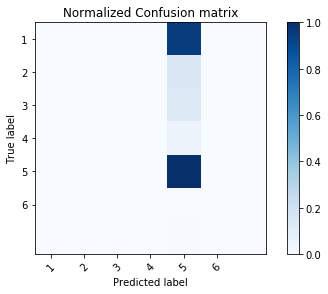

In [39]:
def plot_confusion_matrix(cm, title='Normalized Confusion matrix', 
                          cmap=plt.cm.get_cmap("Blues")): 
    cm = cm / cm.astype(np.float).sum(axis=1) 
    print "confusion_matrix: \n{}".format(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks = np.arange(6) 
    plt.xticks(tick_marks, [1, 2, 3, 4, 5, 6], rotation=45) 
    plt.yticks(tick_marks, [1, 2, 3, 4, 5, 6]) 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show()

def test_har(): 
    y_true = np.load("data/y_true.npy") 
    y_pred = np.load("data/y_pred.npy") 
    print(classification_report(y_true, y_pred, 
                                target_names = fault_label.values()))
    print(confusion_matrix)
    print(confusion_matrix(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    test_har()